# FCS time-series dataset released by WFP 

In this notebook, we create the time-series regarding the **Food Consumption Score (FCS)** indicator.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ntpath
import glob

In [2]:
# Add the python path to the folder containing some useful custom packages.
import sys
sys.path.insert(0, "../../packages/")
from map_plot import draw_adminstratas
from TsIP.TsIP import TsIP

In [3]:
# Define the path where the results arising from this analysis will be saved.
PATH_TO_SAVE_DATA = "./output_timeseries/"

In [4]:
# Read the data released by wfp regarding the FCS indicator.
path = "./wfp_data/"
all_folders = glob.glob(path + "*")

dfs = []

for folder in all_folders:
    country = ntpath.basename(folder).split(".")[0]
    all_files = glob.glob(path + country + "/*.csv")
    for filename in all_files:
        df = pd.read_csv(filename)
        df["Country"] = country
        dfs.append(df)

In [5]:
print("The data released by wfp:")
df = pd.concat(dfs, axis = 0, ignore_index = True)
df.head()

The data released by wfp:


,SvyDate,Date,Dmgrph,DmgrphCode,Mean_crrnt,Pop,PopNmbr,Country
0,2019-7-15_2019-9-8,2019-09-08,BOUCLE-DU-MOUHOUN,900712.0,30.921705,1976217,611079,Burkina Faso
1,2019-7-15_2019-9-8,2019-09-08,CASCADES,900713.0,22.732405,822445,186961,Burkina Faso
2,2019-7-15_2019-9-8,2019-09-08,CENTRE,900714.0,22.093784,2854356,630635,Burkina Faso
3,2019-7-15_2019-9-8,2019-09-08,CENTRE-EST,900715.0,44.186047,2854356,1261227,Burkina Faso
4,2019-7-15_2019-9-8,2019-09-08,CENTRE-NORD,900716.0,61.948843,1687858,1045608,Burkina Faso


### Brief items description

- *SvyDate*: reference period of the data collection (the value for a reference date is obtained as a mean of a sliding window of some past days where is included the reference date).
- *Date*: reference date (i.e. the end of the reference period). 
- *Dmgrph*: administrative area name.
- *DmgrphCode*: a code for identyfing the adminstrata.
- *Mean_crrnt*: % of people with poor and borderline FCS.
- *Pop*: area population size.
- *PopNmbr*: number of people with poor and borderline FCS (i.e. Mean_crrnt * Pop).

In [6]:
# Check if the dataframe contains NaN values.
print("Check if the dataframe contains some NaN values:")
df.isnull().sum()

Check if the dataframe contains some NaN values:


SvyDate          0
Date             0
Dmgrph           0
DmgrphCode    1620
Mean_crrnt       0
Pop              0
PopNmbr          0
Country          0
dtype: int64

In [7]:
# Let's delete the item 'DmgrphCode' because it is not of interest in this notebook.
df.drop(["DmgrphCode"], axis = 1, inplace = True) 

In [8]:
# Rename some columns items.
df.rename(columns = {"Date": "Datetime", "Dmgrph": "AdminStrata", "Mean_crrnt": "Metric"}, inplace = True)

In [9]:
# Check the temporal ranges of the SvyDate column based on country.
df["SvyDateRange"] = df["SvyDate"].apply(lambda x: pd.to_datetime(x.split("_")[1]) - pd.to_datetime(x.split("_")[0]))
for country in df.Country.unique():
    day_range = df[df.Country == country]["SvyDateRange"].dt.days.unique() + 1 # In order to consider both dates.
    print(country, day_range)

Burkina Faso [56]
Nigeria [31]
Syria [31]
Yemen [31]


This last information is useful to keep in mind when constructing time-series from secondary data sources.

### Country item

In [10]:
print("The countries are:", ", ".join(df.Country.unique()))

The countries are: Burkina Faso, Nigeria, Syria, Yemen


### AdminStrata item

In [11]:
# The strings of AdminStrata key for Burkina Faso country are uppercase, I change them to obtain lowercase with first capital letter.
def to_lower(country, admin):
    if country == "Burkina Faso":
        admin = admin.lower().title()      
    return admin
    
df["AdminStrata"] = df[["Country", "AdminStrata"]].apply(lambda x: to_lower(*x), axis = 1)

In [12]:
AdminStratas = df.groupby("Country")["AdminStrata"].unique()

- **Yemen (YEM)**: the governorates of Yemen are 22, including the capital Sana'a (Amanat Al Asimah) and Socotra archipelago. The FCS dataframe has the values of all the 22 governorates.

In [13]:
print(AdminStratas["Yemen"].shape)
AdminStratas["Yemen"]

(22,)


array(['Abyan', 'Al Hudaydah', 'Al Jawf', 'Al Maharah', 'Al Mahwit',
       'Amanat Al Asimah', 'Amran', 'Dhamar', 'Hadramaut', 'Hajjah',
       'Ibb', 'Lahj', 'Marib', 'Raymah', "Sa'ada", "Sana'a", 'Shabwah',
       'Taizz', 'Aden', 'Al Bayda', "Al Dhale'e", 'Socotra'], dtype=object)

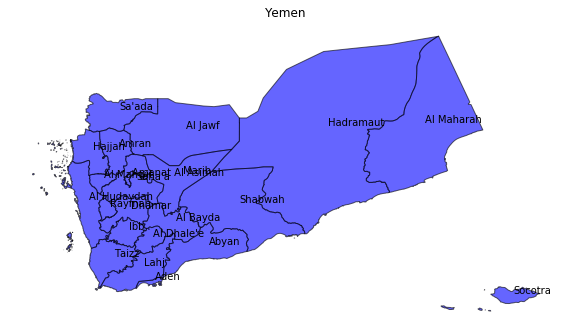

In [14]:
draw_adminstratas("Yemen", AdminStratas["Yemen"], "../Shape Files/shapefiles/Yemen/administrative level 1", figsize = (10, 7), annotation = True)

- **Nigeria (NGA)**: Nigeria is divided into 36 states. It also includes The Federal Capital Territory that is not a state and it is under the direct control of the federal government. The AdminStrata items of the FCS dataframe cover 3 states (Adamawa, Borno and Yobe) and each of these state is diveded into three parts: North, South, Central. This division is referred to the senatorial division of Nigeria. 

In [15]:
print(AdminStratas["Nigeria"].shape)
AdminStratas["Nigeria"]

(9,)


array(['Adamawa Central', 'Adamawa North', 'Adamawa South',
       'Borno Central', 'Borno North', 'Borno South', 'Yobe East',
       'Yobe North', 'Yobe South'], dtype=object)

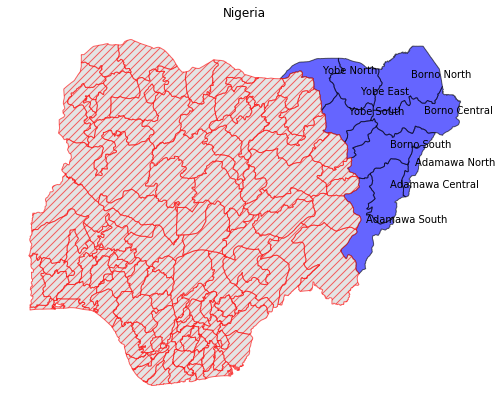

In [16]:
draw_adminstratas("Nigeria", AdminStratas["Nigeria"], "../Shape Files/shapefiles/Nigeria/senatorial districts", figsize = (10, 7), annotation = True, annotation_selected = True)

- **Syria (SYR)**: the governatores of Syria country are 14. The FCS dataframe has the values of 13 governorates (Idleb governatore not included).

In [17]:
print(AdminStratas["Syria"].shape)
AdminStratas["Syria"]

(13,)


array(['Tartous', 'Al-Hasakeh', 'Aleppo', 'As-Sweida', 'Damascus',
       "Dar'a", 'Hama', 'Homs', 'Lattakia', 'Rural Damascus', 'Ar-Raqqa',
       'Deir-ez-Zor', 'Quneitra'], dtype=object)

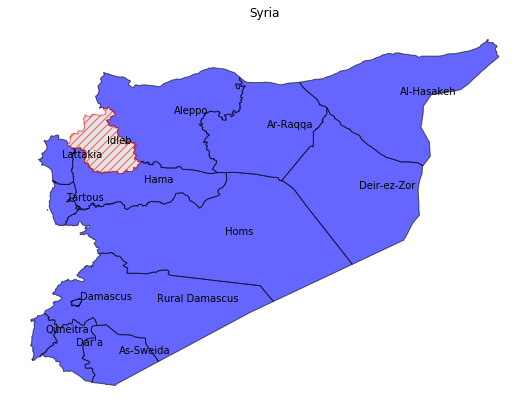

In [18]:
draw_adminstratas("Syria", AdminStratas["Syria"], "../Shape Files/shapefiles/Syria/administrative level 1", figsize = (10, 7), annotation = True)

- **Burkina Faso (BFA)**: Burkina Faso is divided into 13 administrative regions. The FCS dataframe has the values of all 13 regions.

In [19]:
print(AdminStratas["Burkina Faso"].shape)
AdminStratas["Burkina Faso"]

(13,)


array(['Boucle-Du-Mouhoun', 'Cascades', 'Centre', 'Centre-Est',
       'Centre-Nord', 'Centre-Ouest', 'Centre-Sud', 'Est',
       'Hauts-Bassins', 'Nord', 'Plateau-Central', 'Sahel', 'Sud-Ouest'],
      dtype=object)

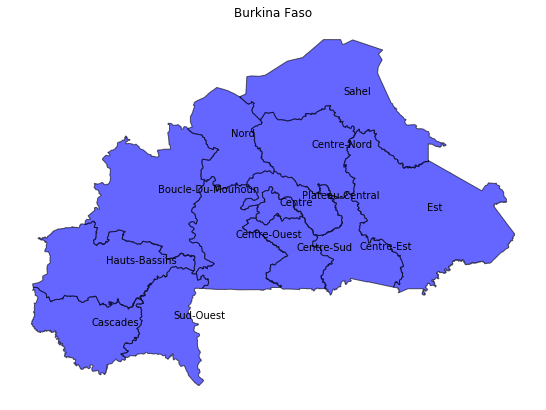

In [20]:
draw_adminstratas("Burkina Faso", AdminStratas["Burkina Faso"], "../Shape Files/shapefiles/Burkina Faso/administrative level 1", figsize = (10, 7), annotation = True)

In [21]:
# Check the min e max values of the Metric.
print("The min and max values of the Metric:")
print(df.Metric.min(), ",", df.Metric.max())

The min and max values of the Metric:
2.24791265253693 , 93.35894621295263


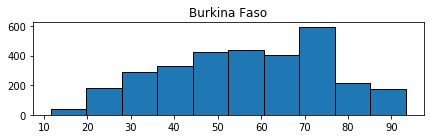

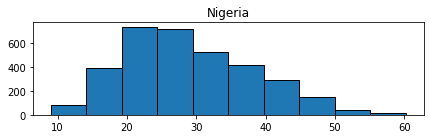

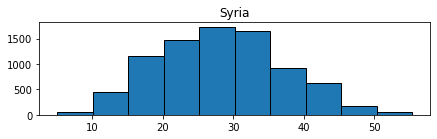

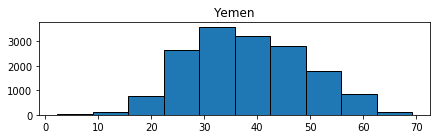

In [22]:
def hist_fcs(group):
    # Plot hist.
    fig, ax = plt.subplots(figsize = (7, 1.7))

    data = group.Metric.dropna().values
    ax.hist(data, ec = "k")
    ax.set_title(group.name)

    plt.show()

df.groupby("Country").apply(hist_fcs);

In [23]:
# Creation of an accurate datetime format.
df.drop(["SvyDate", "SvyDateRange", "Pop", "PopNmbr"], axis = 1, inplace = True) 
df["Datetime"] = pd.to_datetime(df["Datetime"])
df.sort_values("Datetime", ascending = True, inplace = True) 
df = df.groupby(["Country", "AdminStrata"]).apply(lambda group: group.set_index("Datetime").resample("D").mean()).reset_index()
df.reset_index(drop = True, inplace = True)
df.head()

,Country,AdminStrata,Datetime,Metric
0,Burkina Faso,Boucle-Du-Mouhoun,2019-09-08,30.921705
1,Burkina Faso,Boucle-Du-Mouhoun,2019-09-09,31.103928
2,Burkina Faso,Boucle-Du-Mouhoun,2019-09-10,32.030296
3,Burkina Faso,Boucle-Du-Mouhoun,2019-09-11,32.167300
4,Burkina Faso,Boucle-Du-Mouhoun,2019-09-12,31.770045


In [24]:
# Create a dataframe with multi-index column in order to have a summary dataframe of the time-series.
df = df.set_index(["Datetime", "Country", "AdminStrata"]).unstack(["Country", "AdminStrata"])
df.columns = df.columns.droplevel(0)
df.columns = pd.MultiIndex.from_tuples(list(map(lambda x: tuple(list(x) + ["FCS"]), df.columns)))
df.columns.rename("Country", level = 0, inplace = True)
df.columns.rename("AdminStrata", level = 1, inplace = True)
df.columns.rename("Indicator", level = 2, inplace = True)
freq = "D"
df.index.freq = freq
df.head()

Country          Burkina Faso                                         \
AdminStrata Boucle-Du-Mouhoun Cascades Centre Centre-Est Centre-Nord   
Indicator                 FCS      FCS    FCS        FCS         FCS   
Datetime                                                               
2018-07-02                NaN      NaN    NaN        NaN         NaN   
2018-07-03                NaN      NaN    NaN        NaN         NaN   
2018-07-04                NaN      NaN    NaN        NaN         NaN   
2018-07-05                NaN      NaN    NaN        NaN         NaN   
2018-07-06                NaN      NaN    NaN        NaN         NaN   

Country                                                     ...      Yemen  \
AdminStrata Centre-Ouest Centre-Sud Est Hauts-Bassins Nord  ...     Hajjah   
Indicator            FCS        FCS FCS           FCS  FCS  ...        FCS   
Datetime                                                    ...              
2018-07-02           NaN        NaN NaN           NaN  NaN  ...  28.361345   
2018-07-03           NaN        NaN NaN           NaN  NaN  ...  28.805448   
2018-07-04           NaN        NaN NaN           NaN  NaN  ...  30.993706   
2018-07-05           NaN        NaN NaN           NaN  NaN  ...  32.905902   
2018-07-06           NaN        NaN NaN           NaN  NaN  ...  32.598181   

Country                                                                        \
AdminStrata        Ibb       Lahj      Marib     Raymah     Sa'ada     Sana'a   
Indicator          FCS        FCS        FCS        FCS        FCS        FCS   
Datetime                                                                        
2018-07-02   25.036668  31.762436  32.596233  54.121774  17.676022  26.917713   
2018-07-03   27.102390  32.049499  33.333333  56.722689  17.134560  25.783476   
2018-07-04   29.844066  33.106267  36.883683  56.306306  17.454545  25.436047   
2018-07-05   29.025363  32.938828  36.897633  56.231003  17.846350  27.421759   
2018-07-06   30.692766  33.837934  36.669568  57.324841  18.463057  26.547231   

Country                                       
AdminStrata    Shabwah    Socotra      Taizz  
Indicator          FCS        FCS        FCS  
Datetime                                      
2018-07-02   16.752289  23.822825  26.563365  
2018-07-03   18.257453  23.699881  29.124005  
2018-07-04   19.083081  23.103187  29.427973  
2018-07-05   20.349533  21.596419  30.456026  
2018-07-06   21.107524  20.129084  31.012517  

[5 rows x 57 columns]

In [25]:
# Plot time-series.
TsIP(df).interactive_plot_df(matplotlib = False, style = "lines", yaxis = "% of people with poor and borderline FCS", 
                             first_last_valid_index_group = True)

interactive(children=(ToggleButtons(description='Country', options=('Burkina Faso', 'Nigeria', 'Syria', 'Yemen…

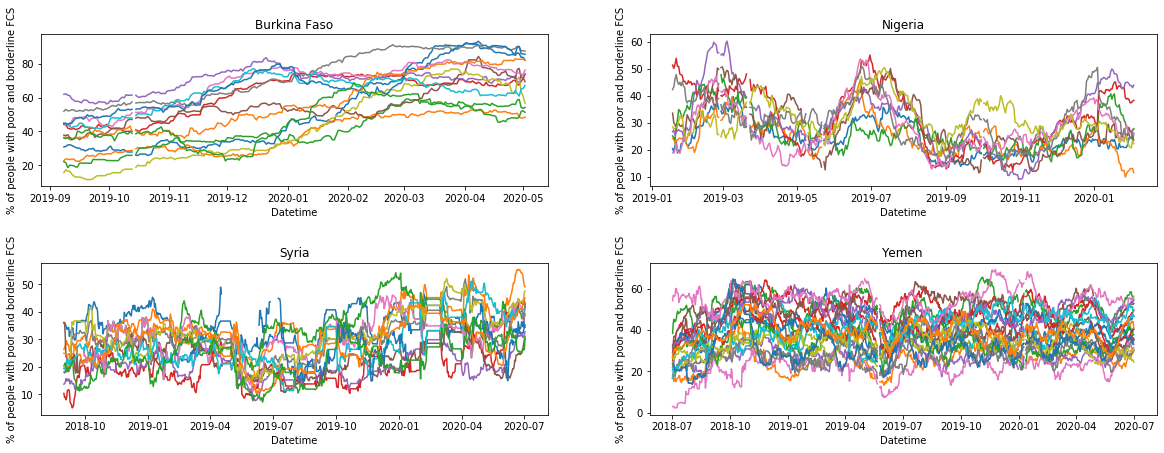

In [26]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 7))
fig.subplots_adjust(hspace = .5)
ax = ax.ravel()
for i, country in enumerate(df.columns.get_level_values(0).unique()):
    ax[i].plot(df[country])
    ax[i].set_title(country)
    ax[i].set_xlabel("Datetime")
    ax[i].set_ylabel("% of people with poor and borderline FCS")

In [27]:
fig.savefig(PATH_TO_SAVE_DATA + "ts.png", dpi = 100)

**ATTENTION**: the adminstratas *Hadramaut* and *Socotra* of the Yemen country have exactly the same time-series for the FCS indicator! 

In [28]:
# Now save the time-series of each country keeping as indeces for each time-series the own first and last valid indeces.
def save(group, name):
    country = group.name
    group = group[country]
    # Adjust time-series group.
    first_idx = group.first_valid_index()
    last_idx = group.last_valid_index()
    group = group.loc[first_idx:last_idx]
    # Save.
    group.to_csv(PATH_TO_SAVE_DATA + country + "/" + name + ".csv", index_label = False)

In [29]:
# Save the dataframe.
df.groupby(level = 0, axis = 1).apply(lambda x: save(x, name = "wfp_fcs"));

## Adjusting the time-series (interpolation nan values)

Let's interpolate the nan values using a linear interpolation up to a limit of 7 days. Finally, we delete the time-series that still have some nan values inside them.

In [30]:
# Let's interpolate the nan values using a linear interpolation up to a limit of 7 days.
def interpolation(group):   
    first_idx = group.first_valid_index()
    last_idx = group.last_valid_index()
    group = group.loc[first_idx:last_idx]
    group = group.interpolate(method = "linear", limit = 7, axis = 0)
    # Delete time-series that still have some NaN values.
    group.dropna(inplace = True, axis = 1)
    return group

df_interpolate = df.groupby(axis = 1, level = [0, 1], group_keys = False).apply(interpolation)
df_interpolate.head()

Country          Burkina Faso                                         \
AdminStrata Boucle-Du-Mouhoun Cascades Centre Centre-Est Centre-Nord   
Indicator                 FCS      FCS    FCS        FCS         FCS   
Datetime                                                               
2018-07-02                NaN      NaN    NaN        NaN         NaN   
2018-07-03                NaN      NaN    NaN        NaN         NaN   
2018-07-04                NaN      NaN    NaN        NaN         NaN   
2018-07-05                NaN      NaN    NaN        NaN         NaN   
2018-07-06                NaN      NaN    NaN        NaN         NaN   

Country                                                     ...      Yemen  \
AdminStrata Centre-Ouest Centre-Sud Est Hauts-Bassins Nord  ...     Hajjah   
Indicator            FCS        FCS FCS           FCS  FCS  ...        FCS   
Datetime                                                    ...              
2018-07-02           NaN        NaN NaN           NaN  NaN  ...  28.361345   
2018-07-03           NaN        NaN NaN           NaN  NaN  ...  28.805448   
2018-07-04           NaN        NaN NaN           NaN  NaN  ...  30.993706   
2018-07-05           NaN        NaN NaN           NaN  NaN  ...  32.905902   
2018-07-06           NaN        NaN NaN           NaN  NaN  ...  32.598181   

Country                                                                        \
AdminStrata        Ibb       Lahj      Marib     Raymah     Sa'ada     Sana'a   
Indicator          FCS        FCS        FCS        FCS        FCS        FCS   
Datetime                                                                        
2018-07-02   25.036668  31.762436  32.596233  54.121774  17.676022  26.917713   
2018-07-03   27.102390  32.049499  33.333333  56.722689  17.134560  25.783476   
2018-07-04   29.844066  33.106267  36.883683  56.306306  17.454545  25.436047   
2018-07-05   29.025363  32.938828  36.897633  56.231003  17.846350  27.421759   
2018-07-06   30.692766  33.837934  36.669568  57.324841  18.463057  26.547231   

Country                                       
AdminStrata    Shabwah    Socotra      Taizz  
Indicator          FCS        FCS        FCS  
Datetime                                      
2018-07-02   16.752289  23.822825  26.563365  
2018-07-03   18.257453  23.699881  29.124005  
2018-07-04   19.083081  23.103187  29.427973  
2018-07-05   20.349533  21.596419  30.456026  
2018-07-06   21.107524  20.129084  31.012517  

[5 rows x 56 columns]

In [31]:
# Check what time-series are dropped.
for column in df.columns:
    if column not in df_interpolate.columns:
        print(column)

('Syria', 'Quneitra', 'FCS')


In [32]:
# Plot time-series.
TsIP(df_interpolate).interactive_plot_df(matplotlib = False, style = "lines", yaxis = "% of people with poor and borderline FCS", 
                                         first_last_valid_index_group = True)

interactive(children=(ToggleButtons(description='Country', options=('Burkina Faso', 'Nigeria', 'Syria', 'Yemen…

In [33]:
# Save these new time-series.
df_interpolate.groupby(level = 0, axis = 1).apply(lambda x: save(x, name = "wfp_fcs-no-nan"));